In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
'''
Functions to preprocess the dataset
'''

# normalises the columns specified for that dataframe
def normalize(df, columns):
    result = df.copy()
    for feature_name in columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# clean the passed data frame
def cleaning(df):
    '''
    df=df.dropna(thresh=7)
    df["Age"] = df.groupby("Community").transform(lambda x: x.fillna(round(x.mean())))
    df['Weight'] = df['Weight'].fillna(df.groupby('Age')['Weight'].transform('mean'))
    #df['Delivery phase'] = df['Delivery phase'].fillna(round((df.groupby('Age')['Delivery phase'].transform('mean'))))
    #df['Delivery phase'] -= 1
    df['HB'] = df['HB'].fillna(round((df.groupby('Age')['HB'].transform('mean'))))
    df['BP'] = df['BP'].fillna(df.groupby('Weight')['BP'].transform('mean'))
    df['Delivery phase']=df['Delivery phase'].fillna(method='ffill')
    df['Education'].fillna(5.0, inplace=True)
    df['Residence']=df['Residence'].fillna(method='ffill')
    df=df.fillna(method="ffill")
    normalized_df = normalize(df, ['Age','Weight','HB','BP',])
    dum_df = pd.get_dummies(normalized_df, columns=["Community"])
    
    return dum_df
    '''
    df=df.dropna(thresh=7)
    df['Education'].fillna(5.0, inplace=True)
    df['Residence']=df['Residence'].fillna(method='ffill')
    df['Delivery phase']=df['Delivery phase'].fillna(method='ffill')
    #df['Age']=df['Age'].fillna(df['Age'].mean())
    df.loc[:,'Age'] = df.groupby("Community").transform(lambda x: x.fillna(round(x.mean())))
    df.loc[:,'Weight']=df['Weight'].fillna(df['Weight'].mean())
    #df['Weight'] = df['Weight'].fillna(df.groupby('Age')['Weight'].transform('mean'))
    df.loc[:,'HB']=df['HB'].fillna(df['HB'].mean())
    #df['HB'] = df['HB'].fillna(round((df.groupby('Age')['HB'].transform('mean'))))
    df.loc[:,'BP'] = df['BP'].fillna(df['BP'].mean())
    #df['BP'] = df['BP'].fillna(df.groupby('Weight')['BP'].transform('mean'))
    
    df=df.fillna(method="ffill")
    normalized_df = normalize(df, ['Age','Weight','HB','BP',])
    return normalized_df
    

In [3]:
'''
Functions used to assist training the model
'''
# sigmoid activation function
# Input :
#       x -> value to apply sigmoid function on
#       derivative -> calculate the derivative sigmoid function on x
# Ouput:
#       sigmoid(x) or derivative of sigmoid(x)
def sigmoid(x, derivative = False):
    if derivative:
        return np.multiply(sigmoid(x),(1-sigmoid(x)))
    return(1/(1 + np.exp(-x))) 

# ReLu activation function
# Though not utilised here, it was tested as a possible candidate  
# Input :
#       x -> value to apply ReLU function on
#       derivative -> calculate the derivative ReLU function on x
# Ouput:
#       ReLU(x) or derivative of ReLU(x)
def ReLU(x, derivative = False):
    if derivative:
        return 1 if x.flatten()[0] > 0 else 0
    return x * (x.flatten()[0] > 0)

# Swish activation function
# Though not utilised here, it was tested as a possible candidate 
# Input :
#       x -> value to apply swish function on
#       derivative -> calculate the derivative swish function on x
# Ouput:
#       swish(x) or derivative of swish(x)
def swish(x, derivative = False):
    if derivative:
        return x / (1. + np.exp(-x)) + (1. / (1. + np.exp(-x))) * (1. - x * (1. / (1. + np.exp(-x))))
    return x*sigmoid(x)

# tanh activation function
# Input :
#       x -> value to apply hyperbolic tangent function on
#       derivative -> calculate the derivative hyperbolic tangent function on x
# Ouput:
#       tanh_f(x) or derivative of tanh_f(x)
def tanh_f(x, derivative = False):
    if derivative:
        return 1 - np.power(x,2)
    return np.tanh(x)

# stores weights and other hyper parameters of the hidden layers in a dictionary parameters
# n_x -> Number of columns in training samples 
# n_hidden1 -> Number of hidden neurons in hidden layer 1 -> 512
# n_hidden2 -> Number of hidden neurons in hidden layer 2 -> 256
# n_hidden3 -> Number of hidden neurons in hidden layer 3 -> 256
# n_y -> Number of output classes -> 1
# alpha -> learning rate -> 8e-6
# max_epochs -> max number of epochs the model will run -> 100
# momentum -> momentum used to implement nesterovs momentum
# decay_rate -> Rate at which the learning rate is 
#               decreased by during each epoch -> alpha/epochs
# n_train -> Number of training samples
# n_test -> Number of testing samples
def initialize_parameters(n_x, n_hidden1, n_hidden2, n_hidden3,
                        n_y, alpha, max_epochs, momentum,
                        decay_rate, n_train,
                        n_test):
    parameters = dict()
    # Use Xaviers initialization of weights, good for tanh function
    # (512, 9)
    parameters['w1'] = np.random.randn(n_hidden1,n_x)*np.sqrt(2/(n_hidden1))
    # (512,1)
    parameters['b1'] = np.random.rand(n_hidden1,1)
    # (256, 512)
    parameters['w2'] = np.random.randn(n_hidden2,n_hidden1)*np.sqrt(2/(n_hidden2)) 
    # (256,1)
    parameters['b2'] = np.random.rand(n_hidden2,1)
    # (512, 256)
    parameters['w3'] = np.random.randn(n_hidden3,n_hidden2)*np.sqrt(2/(n_hidden3))
    # (512,1)
    parameters['b3'] = np.random.rand(n_hidden3,1)
    # (1,512)
    parameters['w4'] = np.random.randn(n_y,n_hidden3)*np.sqrt(2/(n_y)) 
    # (1,1)
    parameters['b4'] = np.random.rand(n_y,1)
    parameters['alpha'] = alpha
    parameters['initial_alpha'] = alpha
    parameters['max_epochs'] = epochs
    parameters['beta'] = momentum
    
    # failed implementation of dropout regularization
    #parameters['do_dropout'] = do_dropout
    #parameters['dropout_percent'] = dropout_percent
    
    parameters['decay'] = decay_rate
    # velocity factors which help in calculating 
    # gradients using momentum
    parameters['v_w1'] = 0
    parameters['v_w2'] = 0
    parameters['v_w3'] = 0
    parameters['v_w4'] = 0
    parameters['v_b1'] = 0
    parameters['v_b2'] = 0
    parameters['v_b3'] = 0
    parameters['v_b4'] = 0
    parameters['n_train'] = n_train
    parameters['n_test'] = n_test
    # failed implementation of batch gradient descent
    #parameters['batch_size'] = batch_size
    return parameters

# binary cross entropy for 2 class classification
def compute_loss(y_hats, Y, parameters):
    
    W1 = parameters['w1']
    W2 = parameters['w2']
    W3 = parameters['w3']
    n_train = parameters['n_train']
    lambd = 0.7
    logloss = np.multiply(np.log(y_hats), Y) + np.multiply(np.log(1-y_hats), (1-Y))
    bce = - np.sum(logloss)/len(Y)
    
    # failed implementation of L2 regularization
    l2_reg = (np.sum(np.square(W1)))*(lambd/len(Y)) + \
        (np.sum(np.square(W2)))*(lambd/(2*len(Y))) + \
        (np.sum(np.square(W3)))*(lambd/(3*len(Y)))
    return bce
    
# accuracy for binary classification
# tp = true positive
# tn = true negative
# Accuracy = (tp+tn)/total samples
def compute_acc(y_hats, Y):
    tp,tn = 0,0
    for i in range(len(Y)):
        y_hats[i] = 1 if y_hats[i] > 0.6 else 0
        if(Y[i]==1 and y_hats[i]==1):
            tp=tp+1
        if(Y[i]==0 and y_hats[i]==0):
            tn=tn+1
    return (tp+tn)/len(Y)
        
# Forward propagation
# Predict the value y_train using x_train
# Activation function stack
# tanh
# tanh
# tanh
# sigmoid
def forward_propagation(x_train, parameters, do_dropout=False):
    W1 = parameters['w1']
    W2 = parameters['w2']
    W3 = parameters['w3']
    W4 = parameters['w4']
    b1 = parameters['b1']
    b2 = parameters['b2']
    b3 = parameters['b3']
    b4 = parameters['b4']
    alpha = parameters['alpha']
    n_train = parameters['n_train']
    
    #dropout_percent = parameters['dropout_percent']
    #keep_probability = 1 - dropout_percent
    
    # store all intermediate values
    cache = dict()
    #forward propagation begins
    
    # action in hidden 1 layer
    # (512,9) . (9,1) = (512,1)
    z1 = np.dot(W1,x_train) + b1
    a1 = tanh_f(z1)
    
    #if do_dropout:
        #a1 *= dropout_mask1
        
    # action in hidden 2 layer
    # (256, 512) . (512,1) = (256,1)
    z2 = np.dot(W2, a1) + b2
    a2 = tanh_f(z2)
    
    #if do_dropout:
    #a2 *= dropout_mask2
    #a2 /= keep_probability
    
    # (512,256) . (256,1) = (512,1)
    z3 = np.dot(W3, a2) + b3
    a3 = tanh_f(z3)
    
    # (1,512) . (512,1) = (1,1)
    z4 = np.dot(W4,a3) + b4
    a4 = sigmoid(z4)
    
    # copy values to cache
    #cache['dropout_mask1'] = dropout_mask1
    #cache['dropout_mask2'] = dropout_mask2
    cache['z1'] = z1
    cache['a1'] = a1
    cache['z2'] = z2
    cache['a2'] = a2
    cache['z3'] = z3
    cache['a3'] = a3
    cache['a4'] = a4
    
    # returns y_hat and intermediate cache values
    return a4,cache

# Used to calculate the gradients for 
# back propagation. 
# Stores all gradients in intermediate 
# dictionary grads_cache
def calculate_gradients(x_train, y_train, parameters,cache, do_dropout=False):
    # load the parameters to be updated
    W1 = parameters['w1']
    W2 = parameters['w2']
    W3 = parameters['w3']
    W4 = parameters['w4']
    b1 = parameters['b1']
    b2 = parameters['b2']
    b3 = parameters['b3']
    b4 = parameters['b4']
    n_train = parameters['n_train']
    v_w1 = parameters['v_w1']
    v_w2 = parameters['v_w2']
    v_w3 = parameters['v_w3']
    v_w4 = parameters['v_w4']
    v_b1 = parameters['v_b1']
    v_b2 = parameters['v_b2']
    v_b3 = parameters['v_b3']
    v_b4 = parameters['v_b4']
    
    # unload values from cache
    z1 = cache['z1'] 
    a1 = cache['a1']
    z2 = cache['z2'] 
    a2 = cache['a2'] 
    z3 = cache['z3'] 
    a3 = cache['a3'] 
    a4 = cache['a4']
    
    grads_cache = dict()
    # (1,1) - (1,1) = (1,1)
    d_z4 =  a4 - y_train
    
    # (1,1) .(1,512) = (1,512)
    d_W4 = np.dot(d_z4, a3.transpose()) 
    d_b4 = np.sum(d_z4, axis = 1, keepdims=True)
    
    # (512,1) . (1,1) = (512,1)
    # (512,1) * (512,1) = (512,1)
    d_z3 = np.multiply(np.dot(W4.transpose(), d_z4), tanh_f(a3, derivative=True))
    # (512,1) . (1, 256) = (512,256)
    d_W3 = np.dot(d_z3, a2.transpose()) 
    d_b3 = np.sum(d_z3, axis=1, keepdims=True)
    
    # (256,512) . (512,1) = (256,1)
    # (256, 1) * (256,1) = (256,1)
    d_z2 = np.multiply(np.dot(W3.transpose(), d_z3), tanh_f(a2, derivative=True))
    # (256,1) . (1, 512) = (256, 512)
    d_W2 =  np.dot(d_z2, a1.transpose()) 
    d_b2 = np.sum(d_z2, axis=1, keepdims=True)
    
    # (512,256) . (256,1) = (512,1)
    # (512,1) * (512,1) = (512,1)
    d_z1 = np.multiply(np.dot(W2.transpose(), d_z2), tanh_f(a1, derivative=True))
    # (512,1) . (1, 9) = (512,9)
    d_W1 = np.dot(d_z1, x_train.transpose())
    d_b1 = np.sum(d_z1, axis=1, keepdims=True)
    
    # save gradients to grad_cache
    grads_cache['d_W4'] = d_W4
    grads_cache['d_b4'] = d_b4
    grads_cache['d_W3'] = d_W3
    grads_cache['d_b3'] = d_b3
    grads_cache['d_W2'] = d_W2
    grads_cache['d_b2'] = d_b2
    grads_cache['d_W1'] = d_W1
    grads_cache['d_b1'] = d_b1
    return grads_cache

# Perform the second part of back propagation
# update parameters for that epoch
def update_parameters(parameters, grad_cache):
    # load parameters
    W1 = parameters['w1']
    W2 = parameters['w2']
    W3 = parameters['w3']
    W4 = parameters['w4']
    b1 = parameters['b1']
    b2 = parameters['b2']
    b3 = parameters['b3']
    b4 = parameters['b4']
    alpha = parameters['alpha']
    n_train = parameters['n_train']
    momentum = parameters['beta']

    v_w1 = parameters['v_w1']
    v_w2 = parameters['v_w2']
    v_w3 = parameters['v_w3']
    v_w4 = parameters['v_w4']
    v_b1 = parameters['v_b1']
    v_b2 = parameters['v_b2']
    v_b3 = parameters['v_b3']
    v_b4 = parameters['v_b4']
    
    # load gradient cache
    d_W1 = grad_cache['d_W1']
    d_W2 = grad_cache['d_W2']
    d_W3 = grad_cache['d_W3']
    d_W4 = grad_cache['d_W4']
    d_b1 = grad_cache['d_b1']
    d_b2 = grad_cache['d_b2']
    d_b3 = grad_cache['d_b3']
    d_b4 = grad_cache['d_b4']
    
    # nesterov momentum
    # implementation taken from
    # https://arxiv.org/pdf/1607.01981.pdf
    v_w1_old = v_w1
    v_w1 = momentum*v_w1 - alpha*d_W1
    v_w2_old = v_w2
    v_w2 = momentum*v_w2 - alpha*d_W2
    v_w3_old = v_w3
    v_w3 = momentum*v_w3 - alpha*d_W3
    v_w4_old = v_w4
    v_w4 = momentum*v_w4 - alpha*d_W4
    v_b1_old = v_b1
    v_b1 = momentum*v_b1 - alpha*d_b1
    v_b2_old = v_b2
    v_b2 = momentum*v_b2 - alpha*d_b2
    v_b3_old = v_b3
    v_b3 = momentum*v_b3 - alpha*d_b3
    v_b4_old = v_b4
    v_b4 = momentum*v_b4 - alpha*d_b4
    #update parameters
    parameters['v_w1'] = v_w1
    parameters['v_w2'] = v_w2
    parameters['v_w3'] = v_w3
    parameters['v_w4'] = v_w4
    parameters['v_b1'] = v_b1
    parameters['v_b2'] = v_b2
    parameters['v_b3'] = v_b3
    parameters['v_b4'] = v_b4
    
    parameters['w1'] = W1 - momentum*v_w1_old + v_w1*(1+momentum)
    parameters['b1'] = b1 - momentum*v_b1_old + v_b1*(1+momentum)
    parameters['w2'] = W2 - momentum*v_w2_old + v_w2*(1+momentum)
    parameters['b2'] = b2 - momentum*v_b2_old + v_b2*(1+momentum)
    parameters['w3'] = W3 - momentum*v_w3_old + v_w3*(1+momentum)
    parameters['b3'] = b3 - momentum*v_b3_old + v_b3*(1+momentum)
    parameters['w4'] = W4 - momentum*v_w4_old + v_w4*(1+momentum)
    parameters['b4'] = b4 - momentum*v_b4_old + v_b4*(1+momentum)
    '''
    Regular SGD
    parameters['w1'] = W1 - alpha*d_W1
    parameters['b1'] = b1 - alpha*d_b1
    parameters['w2'] = W2 - alpha*d_W2
    parameters['b2'] = b2 - alpha*d_b2
    parameters['w3'] = W3 - alpha*d_W3
    parameters['b3'] = b3 - alpha*d_b3
    parameters['w4'] = W4 - alpha*d_W4
    parameters['b4'] = b4 - alpha*d_b4
    '''

In [4]:
'''
Design of a Neural Network from scratch

*************<IMP>*************
Mention hyperparameters used and describe functionality in detail in this space
- carries 1 mark

Learning rate - rate at which model learns the training samples - alpha
Epochs - Number of times the model goes through the training samples
Learning rate decay - Rate at which learning rate reduces every epoch, time based decay
Momentum - Used to speed up convergence, increases value in the direction of gradient
        - helps prevent oscillations 

'''

class NN:

    ''' X and Y are dataframes '''
    
    def fit(self,X,Y):
        '''
        Function that trains the neural network by taking x_train and y_train samples as input
        '''
        global parameters, X_test, Y_test
        epochs = parameters['max_epochs']
        decay_rate = parameters['decay']
        #do_dropout = parameters['do_dropout']
        x_train = []
        
        # create a list of training numpy samples
        for index, row in X.iterrows():
            x_train.append(np.array(row, np.longdouble).reshape(len(row),1))
        #print(x_train)
        y_train = Y.to_numpy()
        y_test = Y_test.to_numpy()
        
        # store accuracy and loss which can later be used for observations
        history = dict()
        history['alpha'] = [parameters['alpha']]
        history['train_acc'] = [0]
        history['train_loss'] = [float('+inf')]
        history['val_loss'] = [float('+inf')]
        history['val_acc'] = [0]
        
        #batch_size = parameters['batch_size']
        n_train = parameters['n_train'] 
        #batches = (n_train//batch_size) + 1
        
        for epoch in range(epochs):
            y_hats = []
            y_test_hats = []  
            
            # batch size 1, default, batch gradient descent did not help us much
            for i in range(len(x_train)):
                y_pred,cache = forward_propagation(x_train[i], parameters)
                y_hats.append(y_pred)
                grads_cache = calculate_gradients(x_train[i], y_train[i], parameters, cache)
                update_parameters(parameters, grads_cache)
            
            # compute loss for that epoch
            train_loss = compute_loss(np.array(y_hats),y_train, parameters)
            # compute accuracy for that epoch
            train_acc = compute_acc(y_hats, y_train)
            # check testing loss
            y_test_hats = self.predict(X_test)
            test_loss = compute_loss(np.array(y_test_hats),y_test, parameters)
            # get testing accuracy
            test_acc = compute_acc(y_test_hats, y_test)
            # print and store all the values
            print(f"Epoch::{epoch+1}/{epochs} ======= loss: {train_loss} - accuracy: {train_acc}\n")
            parameters['alpha'] = parameters['initial_alpha'] *(1/(1+decay_rate*(epoch+1)))
            history['alpha'].append(parameters['alpha'])
            history['train_acc'].append(train_acc)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(test_loss)
            history['val_acc'].append(test_acc)
        print("Training finished")
        return history
            
    def predict(self,X):

        """
        The predict function performs a simple feed forward of weights
        and outputs yhat values 

        yhat is a list of the predicted value for df X
        """
        # go through all training samples, convert to numpy, append prediction to a list and return
        global parameters
        y_hat = []
        for index, row in X.iterrows():
            x_test = np.array(row, np.longdouble).reshape(len(row),1)
            y_pred, cache = forward_propagation(x_test, parameters,do_dropout = False)
            y_hat.append(y_pred)
        return y_hat

    def CM(self, y_test ,y_test_obs):
        '''
        Prints confusion matrix 
        y_test is list of y values in the test dataset
        y_test_obs is list of y values predicted by the model

        '''
        
        for i in range(len(y_test)):
            if(y_test_obs[i].flatten()[0]>0.6):
                y_test_obs[i]=1
            else:
                y_test_obs[i]=0
        print("Y_accc    ", y_test)
        print("Y_test_obs",y_test_obs)
        cm=[[0,0],[0,0]]
        fp=0
        fn=0
        tp=0
        tn=0
        for i in range(len(y_test)):
            if(y_test[i]==1 and y_test_obs[i]==1):
                tp=tp+1
            if(y_test[i]==0 and y_test_obs[i]==0):
                tn=tn+1
            if(y_test[i]==1 and y_test_obs[i]==0):
                fp=fp+1
            if(y_test[i]==0 and y_test_obs[i]==1):
                fn=fn+1
        cm[0][0]=tn
        cm[0][1]=fp
        cm[1][0]=fn
        cm[1][1]=tp

        p= tp/(max(1,tp+fp))
        r=tp/max(1,tp+fn)
        f1=(2*p*r)/max(1,p+r)
        
        print("Confusion Matrix : ")
        print(cm)
        print("\n")
        print(f"Precision : {p}")
        print(f"Recall : {r}")
        print(f"F1 SCORE : {f1}")
        print("Accuracy : ", (tp+tn)/(tp+fp+tn+fn))

In [5]:
PATH = r"F:\Engi_Books\Sem5\MI\UE18CS303_Assignment\Assignment3\data\LBW_clean.csv"
df=pd.read_csv(PATH)
#df = cleaning(raw_df)
#df 
#df.describe()

In [6]:
Y = df["Result"]
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(["Result"],axis = 1), Y, stratify = Y,
                                                    test_size = 0.3, random_state = 1000000007)

In [7]:
X_train.shape[1]

9

In [8]:
# define all the parameters, tweak here to see different results
n_x = X_train.shape[1]
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_hidden1 = 512
n_hidden2 = 256
n_hidden3 = 512
n_y = 1
alpha =8e-6
epochs = 100
momentum = 0.999
#patience = 50
decay_rate = alpha/epochs
parameters = initialize_parameters(n_x = n_x,
                                   n_hidden1 = n_hidden1,
                                   n_hidden3 = n_hidden3,
                                    n_hidden2 = n_hidden2,
                                   n_y = n_y, 
                                    alpha = alpha,
                                   max_epochs = epochs,
                                    n_train = n_train,
                                   momentum = momentum,
                                    n_test = n_test,
                                   decay_rate=decay_rate)
#print(parameters)

In [9]:
neural_network = NN()
history = neural_network.fit(X_train, Y_train)

Epoch::1/100 ======= loss: 81.83958804296144 - accuracy: 0.6461538461538462

Epoch::2/100 ======= loss: 87.9300698907285 - accuracy: 0.5384615384615384

Epoch::3/100 ======= loss: 144.78167700465175 - accuracy: 0.6153846153846154

Epoch::4/100 ======= loss: 189.98370079057506 - accuracy: 0.6153846153846154

Epoch::5/100 ======= loss: 125.37383458038656 - accuracy: 0.6615384615384615

Epoch::6/100 ======= loss: 86.4653699225497 - accuracy: 0.676923076923077

Epoch::7/100 ======= loss: 66.83032523429253 - accuracy: 0.676923076923077

Epoch::8/100 ======= loss: 50.891250218694275 - accuracy: 0.6307692307692307

Epoch::9/100 ======= loss: 50.6718840299326 - accuracy: 0.6461538461538462

Epoch::10/100 ======= loss: 41.87377781298316 - accuracy: 0.6307692307692307

Epoch::11/100 ======= loss: 43.01712675599968 - accuracy: 0.6923076923076923

Epoch::12/100 ======= loss: 48.68876553823884 - accuracy: 0.7076923076923077

Epoch::13/100 ======= loss: 50.29545232021319 - accuracy: 0.69230769230769

In [10]:
y_preds = neural_network.predict(X_test)

In [11]:
neural_network.CM(Y_test.tolist(), y_preds)

Y_accc     [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
Y_test_obs [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
Confusion Matrix : 
[[5, 2], [2, 19]]


Precision : 0.9047619047619048
Recall : 0.9047619047619048
F1 SCORE : 0.9047619047619048
Accuracy :  0.8571428571428571


Text(0.5, 0, 'Epochs:')

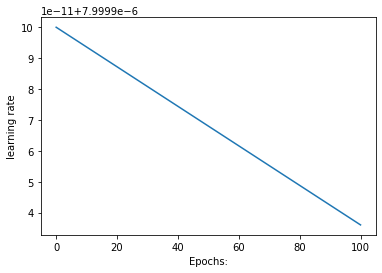

In [12]:
plt.figure()
plt.plot(history['alpha']) 
plt.ylabel('learning rate') 
plt.xlabel("Epochs:")

Text(0.5, 0, 'Epochs:')

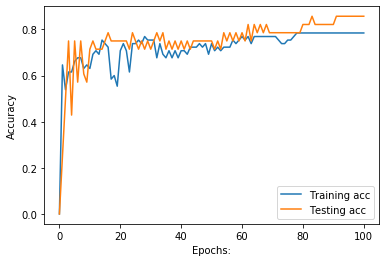

In [13]:
plt.figure()
plt.plot(history['train_acc'], label="Training acc") 
plt.plot(history['val_acc'], label="Testing acc") 
plt.legend()
plt.ylabel('Accuracy') 
plt.xlabel("Epochs:")

Text(0.5, 0, 'Epochs:')

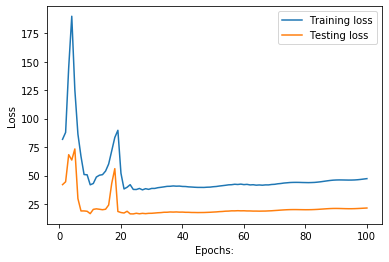

In [14]:
plt.figure()
plt.plot(history['train_loss'], label="Training loss") 
plt.plot(history['val_loss'], label="Testing loss") 
plt.legend()
plt.ylabel('Loss') 
plt.xlabel("Epochs:")